In [1]:
from sklearn.metrics import roc_auc_score, f1_score
import torch
from torch.utils.data import DataLoader
from models import Hyper_GAT_Model
from data.dataset import EEGGraphFeatureDataset
from data.dataset import EEGDatasetWrapper

import pandas as pd
from utils.utils import (
    load_config,
)


/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")
cfg = load_config("configs/hyper_gat.yaml")

In [3]:
dataset_wrapper = EEGDatasetWrapper(
        cfg["data"]["data_dir"], cfg["data"]["preprocessing"]
    )
test_dataset = dataset_wrapper.test_dataset()
test_dataset = EEGGraphFeatureDataset(test_dataset, window_size=cfg["model"]["windows_size"])

input_dim = test_dataset[0][0].shape[1]



model = Hyper_GAT_Model(
        input_dim=input_dim,
        gat_hidden_dim=cfg["model"]["gat_hidden_dim"],
        output_dim=cfg["model"]["output_dim"],
        gat_heads=cfg["model"]["gat_heads"],
        gat_layers=cfg["model"]["gat_layers"],
    ).to(device)

model_path = cfg["training"]["best_model_path"]
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

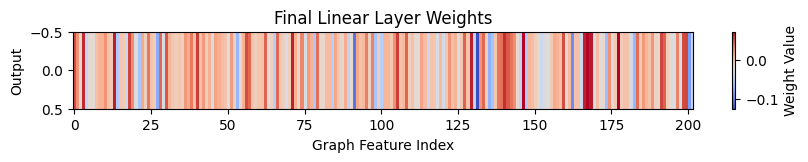

In [5]:
import matplotlib.pyplot as plt

weight = model.fc.weight.detach().cpu().numpy()
plt.figure(figsize=(10, 1))
plt.imshow(weight, aspect='auto', cmap='coolwarm')
plt.colorbar(label="Weight Value")
plt.title("Final Linear Layer Weights")
plt.xlabel("Graph Feature Index")
plt.ylabel("Output")
plt.show()

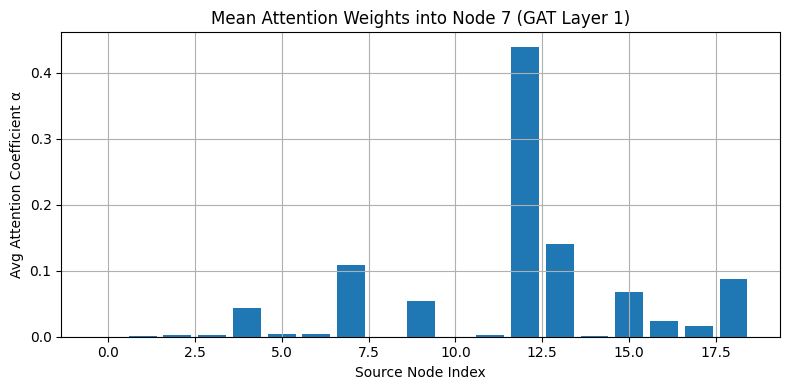

In [16]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def plot_gat_attention_for_first_node(model, x):
    model.eval()
    with torch.no_grad():
        _, num_windows, _, num_electrodes = x.shape
        edge_index = model.build_spatiotemporal_graph(num_electrodes, num_windows).to(x.device)

        # Flatten input: (1, W, F, E) → (W * E, F)
        nodes = x[0].permute(0, 2, 1).reshape(num_windows * num_electrodes, -1)

        # GAT layer with attention output
        out, (edge_index_used, alpha) = model.gats[0](nodes, edge_index, return_attention_weights=True)

        # Choose node index to visualize
        first_node_idx = 7

        # Filter edges where this node is the target
        target_mask = (edge_index_used[1] == first_node_idx)

        sources = edge_index_used[0][target_mask].cpu().numpy()
        attention_values = alpha[target_mask].mean(dim=1).cpu().numpy()  # Average over heads

        # Plot
        plt.figure(figsize=(8, 4))
        plt.bar(sources, attention_values)
        plt.xlabel("Source Node Index")
        plt.ylabel("Avg Attention Coefficient α")
        plt.title(f"Mean Attention Weights into Node {first_node_idx} (GAT Layer 1)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Usage
plot_gat_attention_for_first_node(model, test_dataset[100][0].unsqueeze(0))


In [ ]:
# print shape of dataset[0][0]
print("Shape of dataset[0][0]:", test_dataset[0][0].shape)